## Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `11_delta_dce_categories_check` 
### Recreating the delta dce categories from Susan's R notebook
* Also, checking a few things to make sure we have everything set, this is a v2 of the first notebook 11

created by Cassie Lumbrazo\
last updated: June 2025\
run location: UAS remote linux\
python environment: **cer_treatment**

In [1]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import scipy

In [2]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [3]:
# figure_path = 'C:\\Users\\Lumbr\\OneDrive - University of Alaska\\UW_OneDrive\\EasternCascades\\Writing\\5_Manuscript\\2_PostDefense\\python_figures\\' # Cassie new figure path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

Ordering:

## DeltaDCE Catgeories, 
1. Category 1: Forest Growth (forest to denser forest) --> non-treatment area  
2. Catgeory 2: Forest Thinning (forest to forest edge) --> treatment area 
3. Catgeory 3: No Change --> non-treatment area
4. Catgeory 4: Forest Growth (open to less open) --> non-treatment area 
5. Catgeory 5: Forest Thinning (open to more open) --> treatment area 
6. Catgeory 6: Forest Thinning (forest to open) --> treatment area 


In [4]:
color_cat1='olivedrab' # forest growth (forest to denser forest)
color_cat2='cornflowerblue' # forest thinning (forest to forest edge)
color_cat3='black' # no change (delta DCE close to zero)
color_cat4='mediumseagreen' # forest growth (open to less open)
color_cat5='saddlebrown' # forest thinning (open to more open)
color_cat6='darkslateblue' # forest thinning (forest to open)

In [5]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

Now, we have our delta_dce categories but we also need to do the following, (paragraph from manuscript)

"The snow depth values for both years for the delta DCE category 3 (no change) were used to compute mean values of 0.37 and 0.40 m for 2021 and 2023, respectively, and standard deviations of 0.32 and 0.22. These values were used to normalize snow depth for all pixels in each year as the number of standard deviations away from the mean value."

In [6]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Now, do the same for the difference in normalized snow depth between the two years, but also do it by aspect 

In [7]:
# difference in normalized snow depth by delta DCE category
ds['hs_diff_normalized_delta_dce_cat_1'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 1)
ds['hs_diff_normalized_delta_dce_cat_2'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 2)
ds['hs_diff_normalized_delta_dce_cat_3'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 3)
ds['hs_diff_normalized_delta_dce_cat_4'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 4)
ds['hs_diff_normalized_delta_dce_cat_5'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 5)
ds['hs_diff_normalized_delta_dce_cat_6'] = ds['hs_diff_normalized'].where(ds['delta_dce_cat'] == 6)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_s'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_2_s'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_3_s'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_4_s'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_5_s'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_normalized_delta_dce_cat_6_s'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] ==  1)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_normalized_delta_dce_cat_1_n'] = ds['hs_diff_normalized_delta_dce_cat_1'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_2_n'] = ds['hs_diff_normalized_delta_dce_cat_2'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_3_n'] = ds['hs_diff_normalized_delta_dce_cat_3'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_4_n'] = ds['hs_diff_normalized_delta_dce_cat_4'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_5_n'] = ds['hs_diff_normalized_delta_dce_cat_5'].where(ds['baf_ridge'] == -1)
ds['hs_diff_normalized_delta_dce_cat_6_n'] = ds['hs_diff_normalized_delta_dce_cat_6'].where(ds['baf_ridge'] == -1)

Now, it's plot this and take a look as CDFs

### Normalized, exact copy of Figure 7

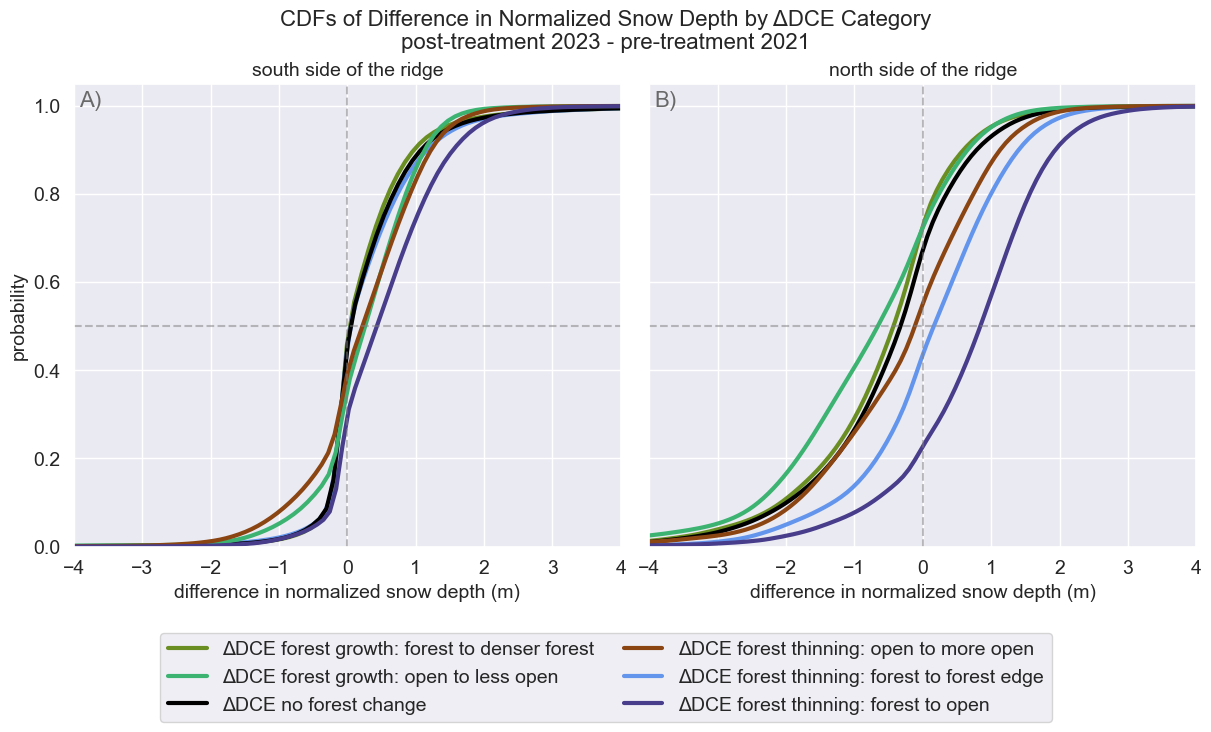

In [8]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='olivedrab', label='ΔDCE forest growth: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='cornflowerblue',    label='ΔDCE forest thinning: forest to forest edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='black',      label='ΔDCE no forest change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='mediumseagreen',      label='ΔDCE forest growth: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='saddlebrown',       label='ΔDCE forest thinning: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='darkslateblue',    label='ΔDCE forest thinning: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='olivedrab', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='cornflowerblue',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='black',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='mediumseagreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='saddlebrown',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_normalized_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='darkslateblue',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in normalized snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

axes[0].set_xlim(-4,4)

plt.suptitle('CDFs of Difference in Normalized Snow Depth by ΔDCE Category\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
# Get the handles and labels from axes[0]
handles, labels = axes[0].get_legend_handles_labels()

# Define custom grouping for legend columns
# Left column: forest growth + no change
left_labels = [
    'ΔDCE forest growth: forest to denser forest',
    'ΔDCE forest growth: open to less open',
    'ΔDCE no forest change'
]
# Right column: forest thinning
right_labels = [
    'ΔDCE forest thinning: open to more open',
    'ΔDCE forest thinning: forest to forest edge',
    'ΔDCE forest thinning: forest to open'
]

# Match handles to labels manually
left_handles = [handles[labels.index(lbl)] for lbl in left_labels]
right_handles = [handles[labels.index(lbl)] for lbl in right_labels]

# Combine in the order you want: left column first, then right
all_handles = left_handles + right_handles
all_labels = left_labels + right_labels

fig.legend(
    all_handles,
    all_labels,
    bbox_to_anchor=(0.5, -0.12),
    loc='center',
    ncol=2,
    fontsize=fontsize_num,
    columnspacing=1.5
)


# fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=2, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

plt.show()

### Now, plot the non-normalized difference in snow depth

In [9]:
ds['hs_diff'] = ds['hs_rapid'] - ds['hs_ncalm']

# difference in snow depth by delta DCE category
ds['hs_diff_delta_dce_cat_1'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 1)
ds['hs_diff_delta_dce_cat_2'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 2)
ds['hs_diff_delta_dce_cat_3'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 3)
ds['hs_diff_delta_dce_cat_4'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 4)
ds['hs_diff_delta_dce_cat_5'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 5)
ds['hs_diff_delta_dce_cat_6'] = ds['hs_diff'].where(ds['delta_dce_cat'] == 6)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_delta_dce_cat_1_s'] = ds['hs_diff_delta_dce_cat_1'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_2_s'] = ds['hs_diff_delta_dce_cat_2'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_3_s'] = ds['hs_diff_delta_dce_cat_3'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_4_s'] = ds['hs_diff_delta_dce_cat_4'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_5_s'] = ds['hs_diff_delta_dce_cat_5'].where(ds['baf_ridge'] ==  1)
ds['hs_diff_delta_dce_cat_6_s'] = ds['hs_diff_delta_dce_cat_6'].where(ds['baf_ridge'] ==  1)

# now, create a variable for the north and south sides of the ridge 
ds['hs_diff_delta_dce_cat_1_n'] = ds['hs_diff_delta_dce_cat_1'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_2_n'] = ds['hs_diff_delta_dce_cat_2'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_3_n'] = ds['hs_diff_delta_dce_cat_3'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_4_n'] = ds['hs_diff_delta_dce_cat_4'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_5_n'] = ds['hs_diff_delta_dce_cat_5'].where(ds['baf_ridge'] == -1)
ds['hs_diff_delta_dce_cat_6_n'] = ds['hs_diff_delta_dce_cat_6'].where(ds['baf_ridge'] == -1)

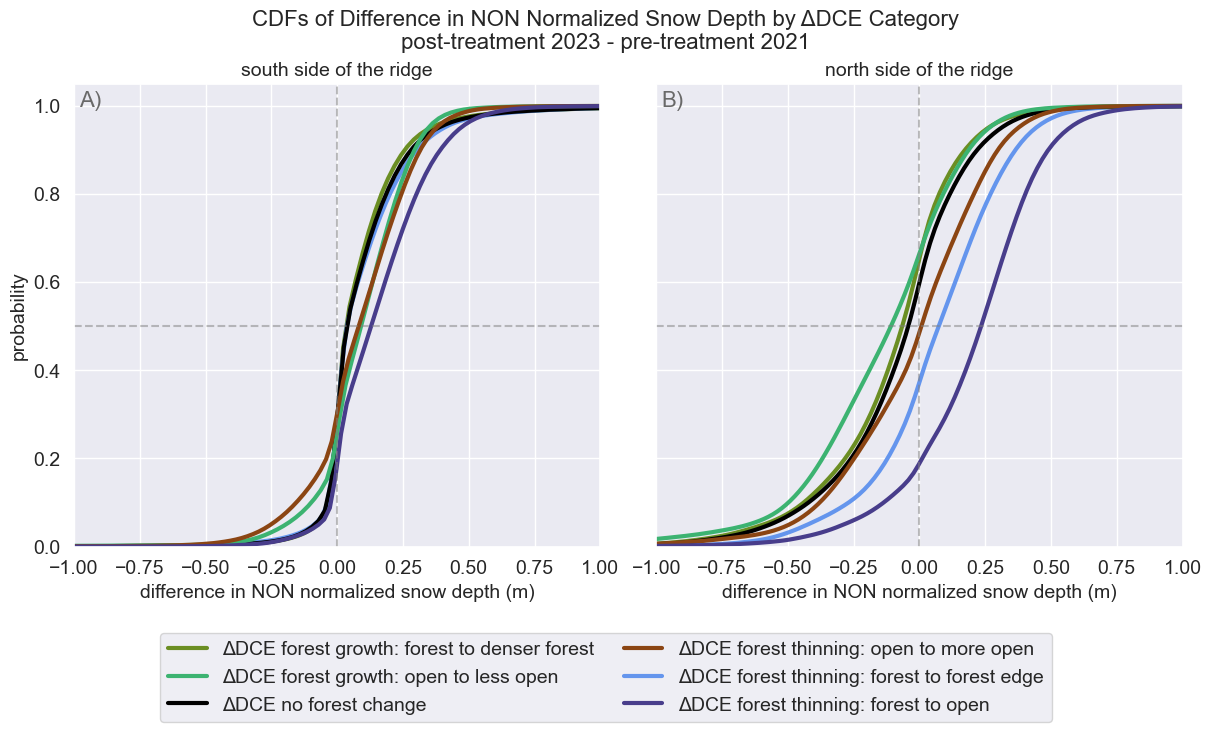

In [10]:
# plot of a histogram of all those variables 
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6), constrained_layout = True)
alpha=0.7

# plots
sns.kdeplot(ds['hs_diff_delta_dce_cat_1_s'].values.flatten(), ax=axes[0], color='olivedrab', label='ΔDCE forest growth: forest to denser forest', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_2_s'].values.flatten(), ax=axes[0], color='cornflowerblue',    label='ΔDCE forest thinning: forest to forest edge', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_3_s'].values.flatten(), ax=axes[0], color='black',      label='ΔDCE no forest change', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_4_s'].values.flatten(), ax=axes[0], color='mediumseagreen',      label='ΔDCE forest growth: open to less open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_5_s'].values.flatten(), ax=axes[0], color='saddlebrown',       label='ΔDCE forest thinning: open to more open', cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_6_s'].values.flatten(), ax=axes[0], color='darkslateblue',    label='ΔDCE forest thinning: forest to open', cumulative=True, linewidth=3)

sns.kdeplot(ds['hs_diff_delta_dce_cat_1_n'].values.flatten(), ax=axes[1], color='olivedrab', label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_2_n'].values.flatten(), ax=axes[1], color='cornflowerblue',    label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_3_n'].values.flatten(), ax=axes[1], color='black',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_4_n'].values.flatten(), ax=axes[1], color='mediumseagreen',      label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_5_n'].values.flatten(), ax=axes[1], color='saddlebrown',       label=None, cumulative=True, linewidth=3)
sns.kdeplot(ds['hs_diff_delta_dce_cat_6_n'].values.flatten(), ax=axes[1], color='darkslateblue',    label=None, cumulative=True, linewidth=3)

# labels
fontsize_num = 14
axes[0].set_title('south side of the ridge', fontsize=fontsize_num)
axes[1].set_title('north side of the ridge', fontsize=fontsize_num)

axes[0].set_xlabel('difference in NON normalized snow depth (m)', fontsize=fontsize_num)
axes[1].set_xlabel('difference in NON normalized snow depth (m)', fontsize=fontsize_num)

axes[0].set_ylabel('probability', fontsize=fontsize_num)
axes[1].set_ylabel('')

# axes[0].set_xlim(-4,4)
axes[0].set_xlim(-1,1)

plt.suptitle('CDFs of Difference in NON Normalized Snow Depth by ΔDCE Category\npost-treatment 2023 - pre-treatment 2021', fontsize=16)
# axes[0].legend(loc='upper left')
# axes[1].legend(loc='upper left')
# Get the handles and labels from axes[0]
handles, labels = axes[0].get_legend_handles_labels()

# Define custom grouping for legend columns
# Left column: forest growth + no change
left_labels = [
    'ΔDCE forest growth: forest to denser forest',
    'ΔDCE forest growth: open to less open',
    'ΔDCE no forest change'
]
# Right column: forest thinning
right_labels = [
    'ΔDCE forest thinning: open to more open',
    'ΔDCE forest thinning: forest to forest edge',
    'ΔDCE forest thinning: forest to open'
]

# Match handles to labels manually
left_handles = [handles[labels.index(lbl)] for lbl in left_labels]
right_handles = [handles[labels.index(lbl)] for lbl in right_labels]

# Combine in the order you want: left column first, then right
all_handles = left_handles + right_handles
all_labels = left_labels + right_labels

fig.legend(
    all_handles,
    all_labels,
    bbox_to_anchor=(0.5, -0.12),
    loc='center',
    ncol=2,
    fontsize=fontsize_num,
    columnspacing=1.5
)


# fig.legend(bbox_to_anchor=(0.5,-0.18), loc='center', ncol=2, fontsize = fontsize_num)

# increase the size of tick marks 
axes[0].tick_params(axis='both', labelsize=fontsize_num)
axes[1].tick_params(axis='both', labelsize=fontsize_num)

# add an A), B) to the figure 
axes[0].text(0.01, 0.95, 'A)', fontsize=16, color='dimgray', transform=axes[0].transAxes)
axes[1].text(0.01, 0.95, 'B)', fontsize=16, color='dimgray', transform=axes[1].transAxes)

# add thin grey lines at 0.5 y axis and 0 x axis 
axes[0].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[1].axhline(0.5, color='grey', linestyle='--', alpha=0.5)
axes[0].axvline(0, color='grey', linestyle='--', alpha=0.5)
axes[1].axvline(0, color='grey', linestyle='--', alpha=0.5)

plt.show()

Now, we are looking at the SCALE difference here... that's what was confusing me. I wasn't looking closely before.

## Checking the Spam of DCE within each Category
especially for the no change group

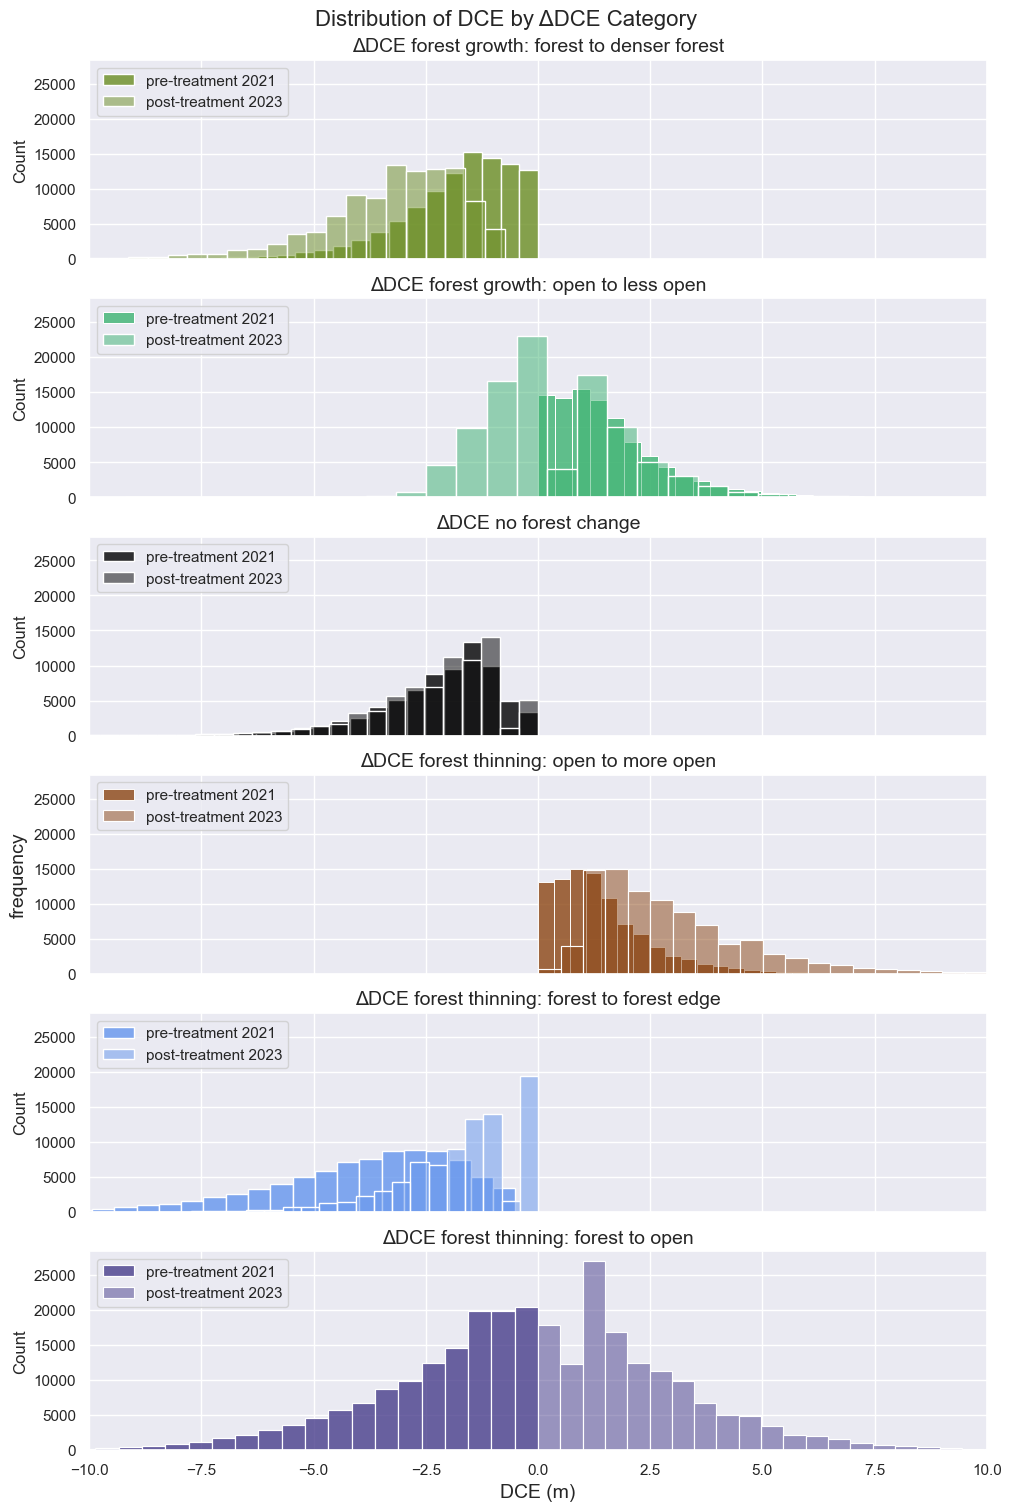

In [11]:
# Now, I want to plot historgrams of the DCE distribution for each category
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,15), constrained_layout = True)
alpha_1=0.8
alpha_2=0.5


# category 1: forest to denser forest
axes[0].set_title('ΔDCE forest growth: forest to denser forest', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 1).values.flatten(), bins=30, ax=axes[0], color=color_cat1, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 1).values.flatten(), bins=30, ax=axes[0], color=color_cat1, alpha=alpha_2, label='post-treatment 2023')


# category 2: forest to edge
axes[4].set_title('ΔDCE forest thinning: forest to forest edge', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 2).values.flatten(), bins=30, ax=axes[4], color=color_cat2, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 2).values.flatten(), bins=30, ax=axes[4], color=color_cat2, alpha=alpha_2, label='post-treatment 2023')

# category 3: no change
axes[2].set_title('ΔDCE no forest change', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 3).values.flatten(), bins=30, ax=axes[2], color=color_cat3, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 3).values.flatten(), bins=30, ax=axes[2], color=color_cat3, alpha=alpha_2, label='post-treatment 2023')

# category 4: open to less open
axes[1].set_title('ΔDCE forest growth: open to less open', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 4).values.flatten(), bins=30, ax=axes[1], color=color_cat4, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 4).values.flatten(), bins=30, ax=axes[1], color=color_cat4, alpha=alpha_2, label='post-treatment 2023')

# category 5: open to more open
axes[3].set_title('ΔDCE forest thinning: open to more open', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 5).values.flatten(), bins=30, ax=axes[3], color=color_cat5, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 5).values.flatten(), bins=30, ax=axes[3], color=color_cat5, alpha=alpha_2, label='post-treatment 2023')

# category 6: forest to open
axes[5].set_title('ΔDCE forest thinning: forest to open', fontsize=fontsize_num)
sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 6).values.flatten(), bins=30, ax=axes[5], color=color_cat6, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 6).values.flatten(), bins=30, ax=axes[5], color=color_cat6, alpha=alpha_2, label='post-treatment 2023')


fontsize_num = 14
axes[5].set_xlabel('DCE (m)', fontsize=fontsize_num)
axes[3].set_ylabel('frequency', fontsize=fontsize_num)    


# limit x axis from -10 to 10 
for i in range(6):
    axes[i].set_xlim(-10,10)
    axes[i].legend(loc='upper left')

plt.suptitle('Distribution of DCE by ΔDCE Category', fontsize=16)

plt.show()

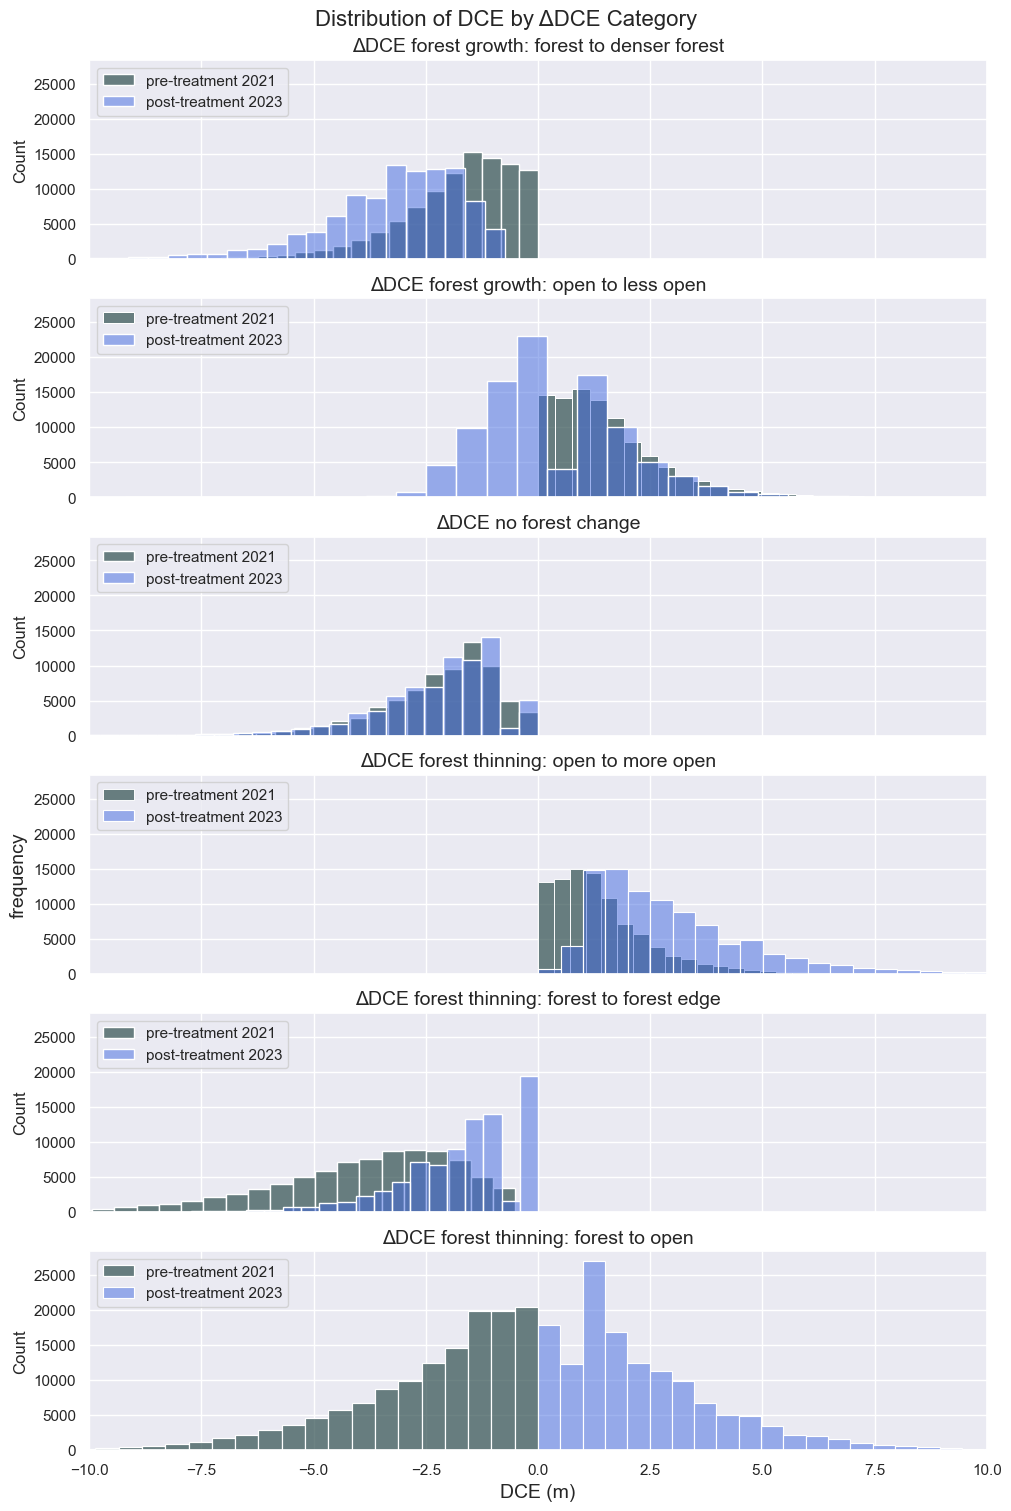

In [12]:
# Now, I want to plot historgrams of the DCE distribution for each category
fig, axes = plt.subplots(6, 1, sharex=True, sharey=True, figsize=(10,15), constrained_layout = True)
alpha_1=0.7
alpha_2=0.5

color_pre='darkslategray'
color_post='royalblue'

# category 1: forest to denser forest
axes[0].set_title('ΔDCE forest growth: forest to denser forest', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 1).values.flatten(), bins=30, ax=axes[0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 1).values.flatten(), bins=30, ax=axes[0], color=color_post, alpha=alpha_2, label='post-treatment 2023')


# category 2: forest to edge
axes[4].set_title('ΔDCE forest thinning: forest to forest edge', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 2).values.flatten(), bins=30, ax=axes[4], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 2).values.flatten(), bins=30, ax=axes[4], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 3: no change
axes[2].set_title('ΔDCE no forest change', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 3).values.flatten(), bins=30, ax=axes[2], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 3).values.flatten(), bins=30, ax=axes[2], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 4: open to less open
axes[1].set_title('ΔDCE forest growth: open to less open', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 4).values.flatten(), bins=30, ax=axes[1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 4).values.flatten(), bins=30, ax=axes[1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 5: open to more open
axes[3].set_title('ΔDCE forest thinning: open to more open', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 5).values.flatten(), bins=30, ax=axes[3], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 5).values.flatten(), bins=30, ax=axes[3], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 6: forest to open
axes[5].set_title('ΔDCE forest thinning: forest to open', fontsize=fontsize_num)
sns.histplot(ds['dce_ncalm'].where(ds['delta_dce_cat'] == 6).values.flatten(), bins=30, ax=axes[5], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where(ds['delta_dce_cat'] == 6).values.flatten(), bins=30, ax=axes[5], color=color_post, alpha=alpha_2, label='post-treatment 2023')


fontsize_num = 14
axes[5].set_xlabel('DCE (m)', fontsize=fontsize_num)
axes[3].set_ylabel('frequency', fontsize=fontsize_num)    


# limit x axis from -10 to 10 
for i in range(6):
    axes[i].set_xlim(-10,10)
    axes[i].legend(loc='upper left')

plt.suptitle('Distribution of DCE by ΔDCE Category', fontsize=16)

plt.show()

### Now, make the same figure, except by north and south sides of the ridge 

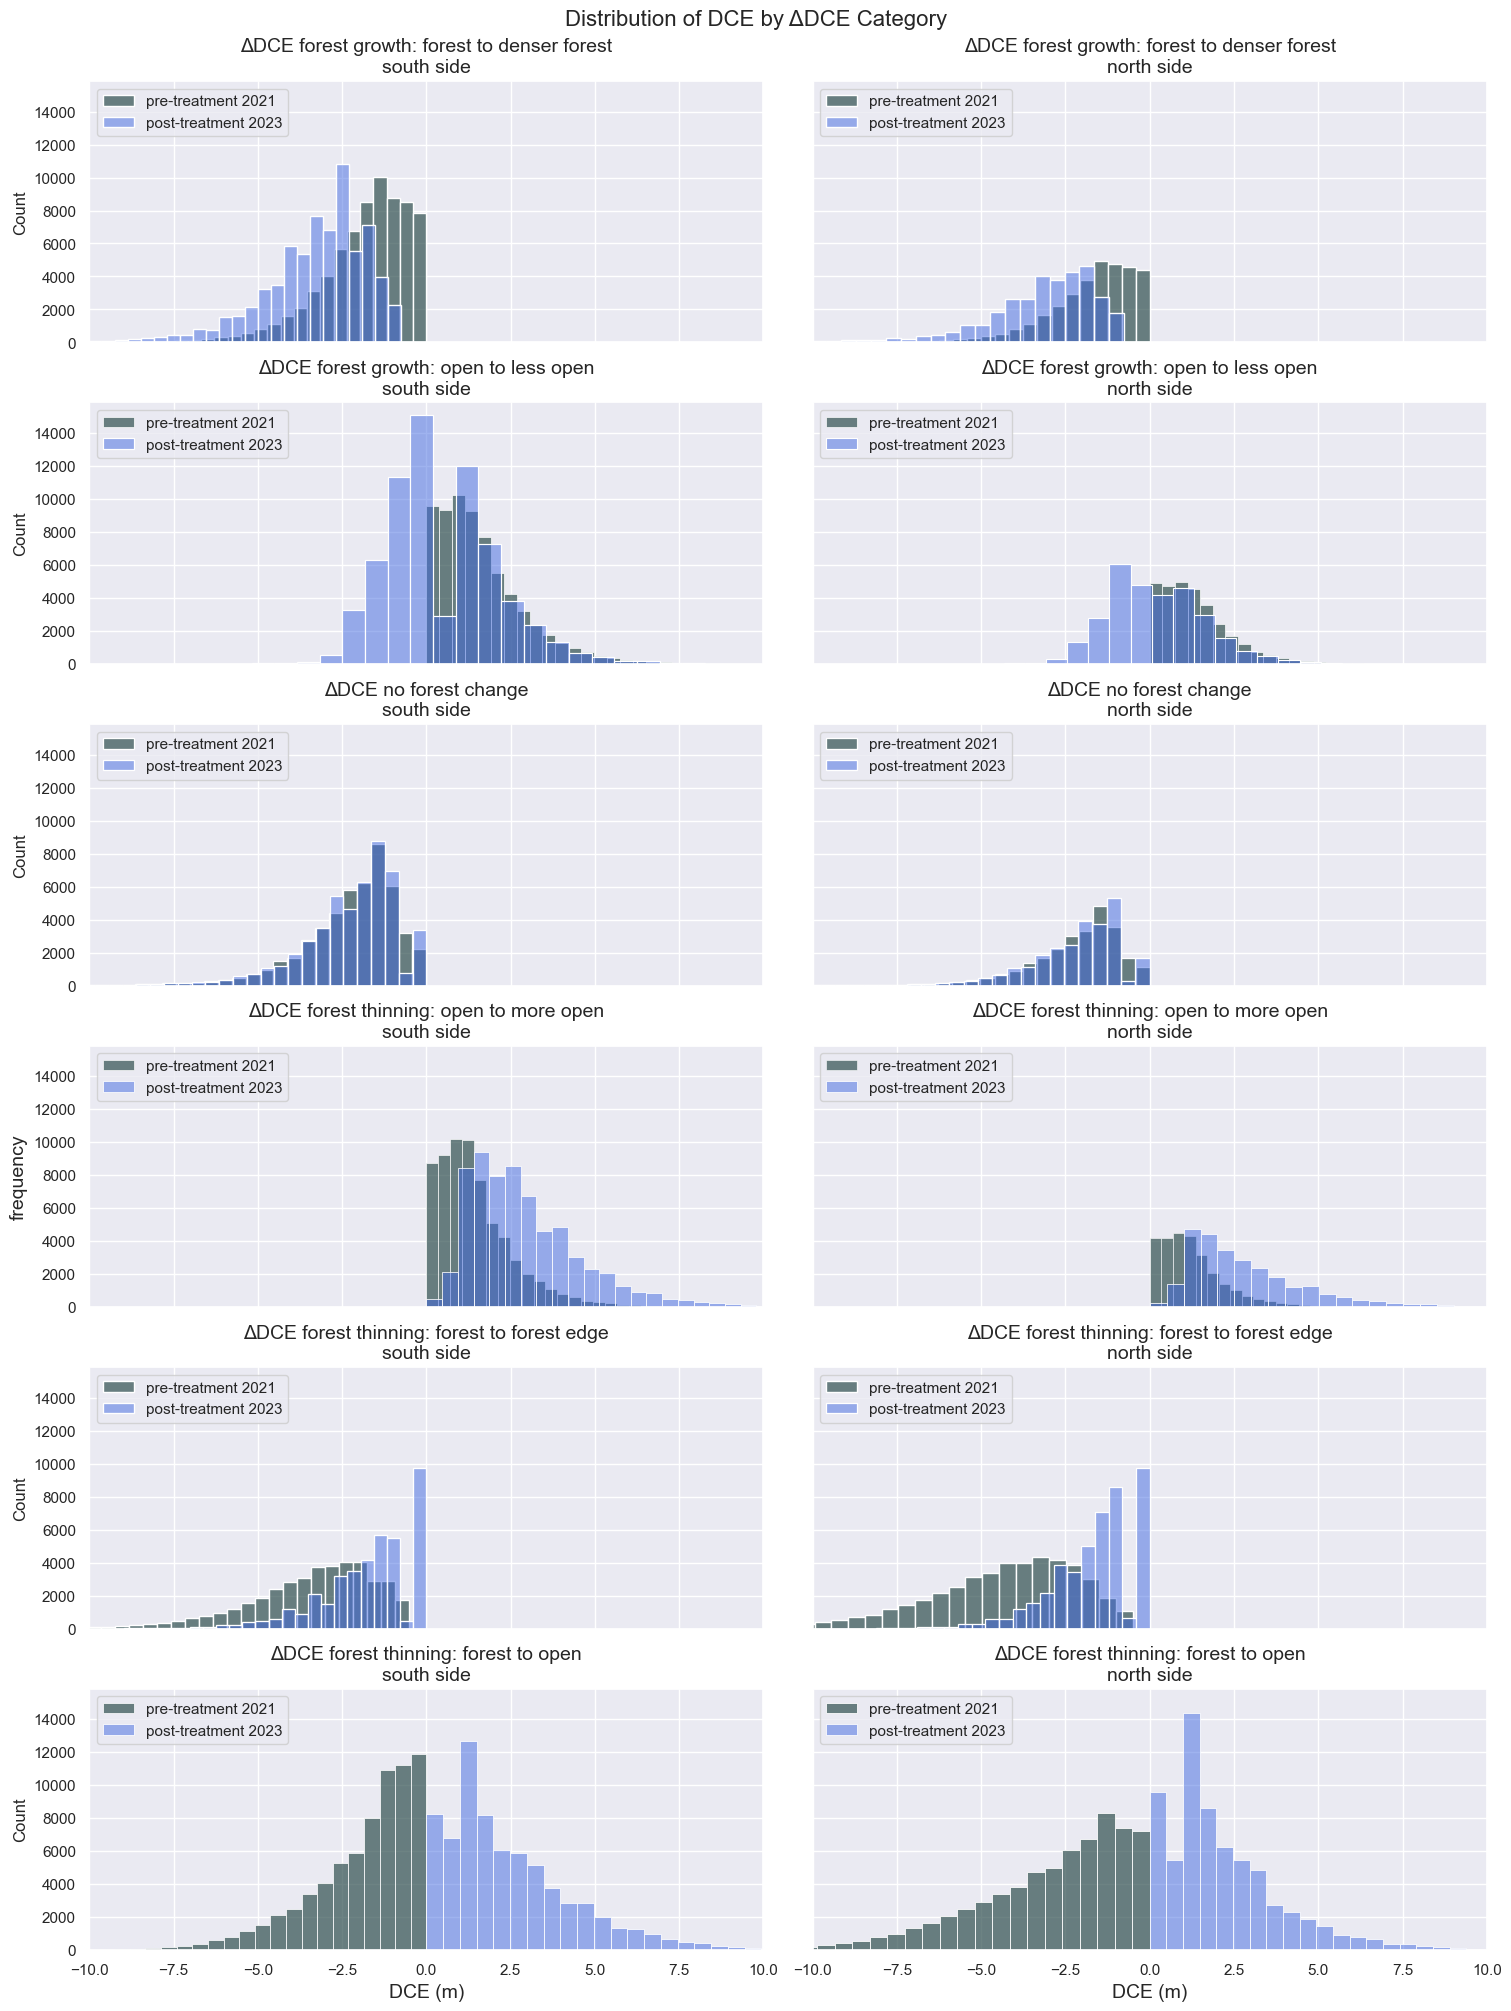

In [13]:
# Now, I want to plot historgrams of the DCE distribution for each category
fig, axes = plt.subplots(6, 2, sharex=True, sharey=True, figsize=(15,20), constrained_layout = True)
alpha_1=0.7
alpha_2=0.5

color_pre='darkslategray'
color_post='royalblue'

# SOUTH SIDE OF THE RIDGE, on the left side and NORTH SIDE OF THE RIDGE on the right side 
# category 1: forest to denser forest
axes[0,0].set_title('ΔDCE forest growth: forest to denser forest\nsouth side', fontsize=fontsize_num)
axes[0,1].set_title('ΔDCE forest growth: forest to denser forest\nnorth side', fontsize=fontsize_num)

# south
sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# north
sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[0,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[0,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')


# category 2: forest to edge
axes[4,0].set_title('ΔDCE forest thinning: forest to forest edge\nsouth side', fontsize=fontsize_num)
axes[4,1].set_title('ΔDCE forest thinning: forest to forest edge\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[4,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[4,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[4,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[4,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 3: no change
axes[2,0].set_title('ΔDCE no forest change\nsouth side', fontsize=fontsize_num)
axes[2,1].set_title('ΔDCE no forest change\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[2,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[2,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[2,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[2,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 4: open to less open
axes[1,0].set_title('ΔDCE forest growth: open to less open\nsouth side', fontsize=fontsize_num)
axes[1,1].set_title('ΔDCE forest growth: open to less open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[1,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[1,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 5: open to more open
axes[3,0].set_title('ΔDCE forest thinning: open to more open\nsouth side', fontsize=fontsize_num)
axes[3,1].set_title('ΔDCE forest thinning: open to more open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[3,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[3,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[3,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[3,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 6: forest to open
axes[5,0].set_title('ΔDCE forest thinning: forest to open\nsouth side', fontsize=fontsize_num)
axes[5,1].set_title('ΔDCE forest thinning: forest to open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[5,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[5,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[5,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[5,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')


fontsize_num = 14
axes[5,0].set_xlabel('DCE (m)', fontsize=fontsize_num)
axes[5,1].set_xlabel('DCE (m)', fontsize=fontsize_num)

axes[3,0].set_ylabel('frequency', fontsize=fontsize_num)    


# limit x axis from -10 to 10 
for i in range(6):
    for j in range(2):
        axes[i,j].set_xlim(-10,10)
        axes[i,j].legend(loc='upper left')

plt.suptitle('Distribution of DCE by ΔDCE Category', fontsize=16)

plt.show()

Now, only look at the `no change` category on it's own...

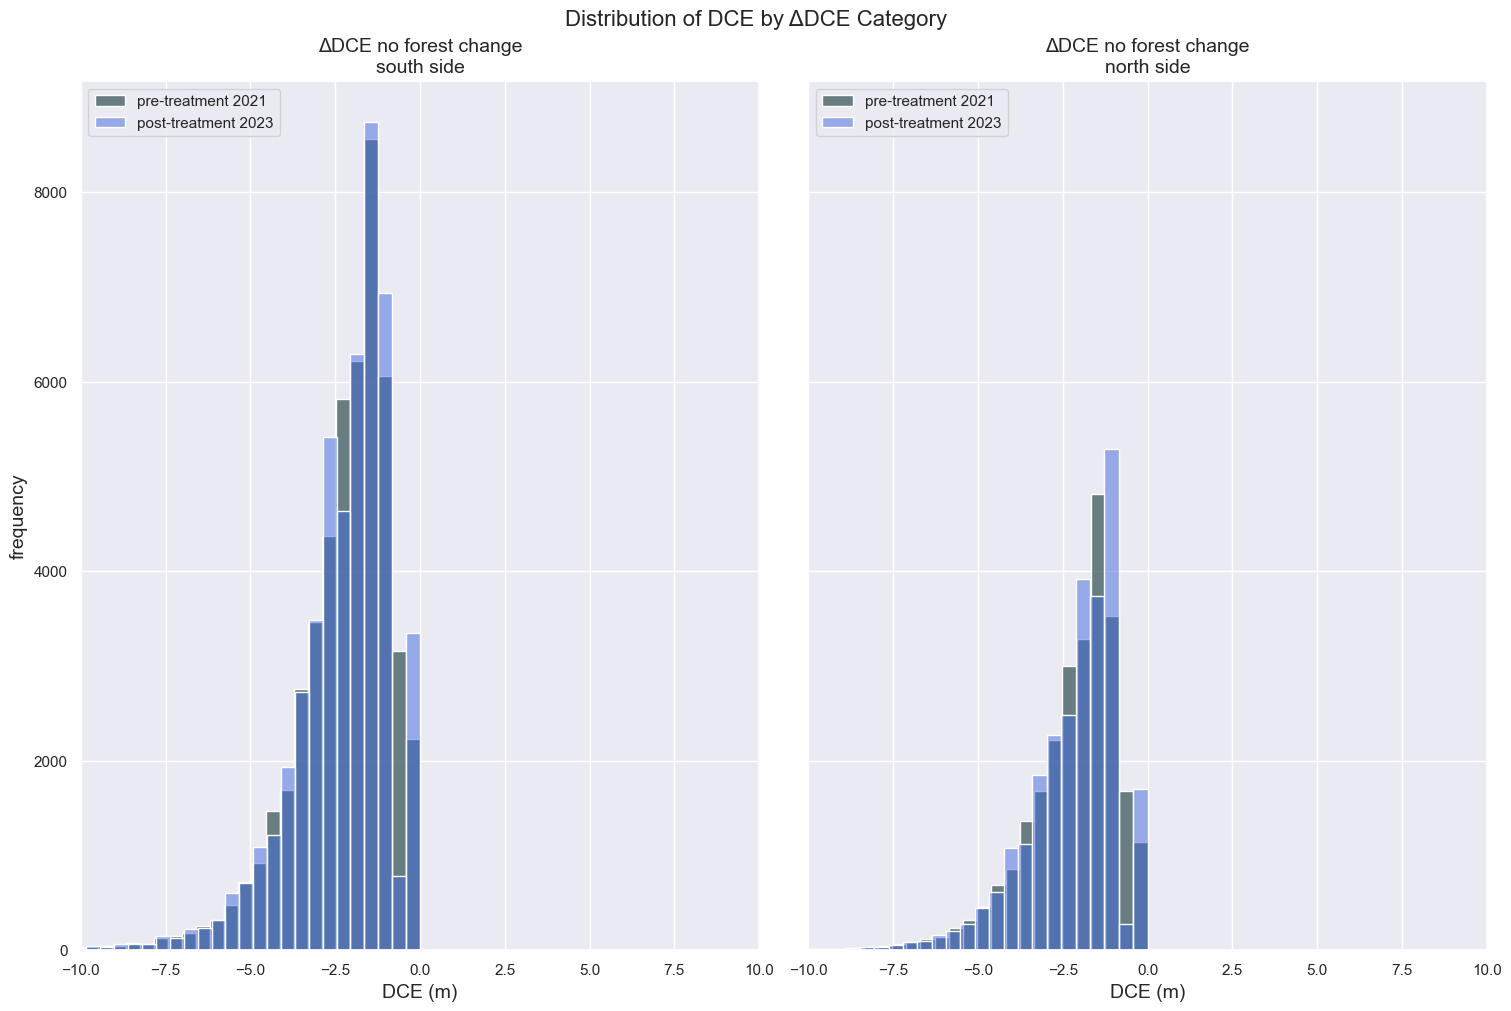

In [14]:
# Now, I want to plot historgrams of the DCE distribution for each category
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,10), constrained_layout = True)
alpha_1=0.7
alpha_2=0.5

color_pre='darkslategray'
color_post='royalblue'

# category 3: no change
axes[0].set_title('ΔDCE no forest change\nsouth side', fontsize=fontsize_num)
axes[1].set_title('ΔDCE no forest change\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['dce_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['dce_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1], color=color_post, alpha=alpha_2, label='post-treatment 2023')


fontsize_num = 14
axes[0].set_xlabel('DCE (m)', fontsize=fontsize_num)
axes[1].set_xlabel('DCE (m)', fontsize=fontsize_num)

axes[0].set_ylabel('frequency', fontsize=fontsize_num)    


# limit x axis from -10 to 10 
for i in range(2):
    axes[i].set_xlim(-10,10)
    # axes[i].set_ylim(0,150)
    axes[i].legend(loc='upper left')

plt.suptitle('Distribution of DCE by ΔDCE Category', fontsize=16)

plt.show()

Now, try plotting just canopy height? 

In [ ]:
ds['chmws_ncalm']

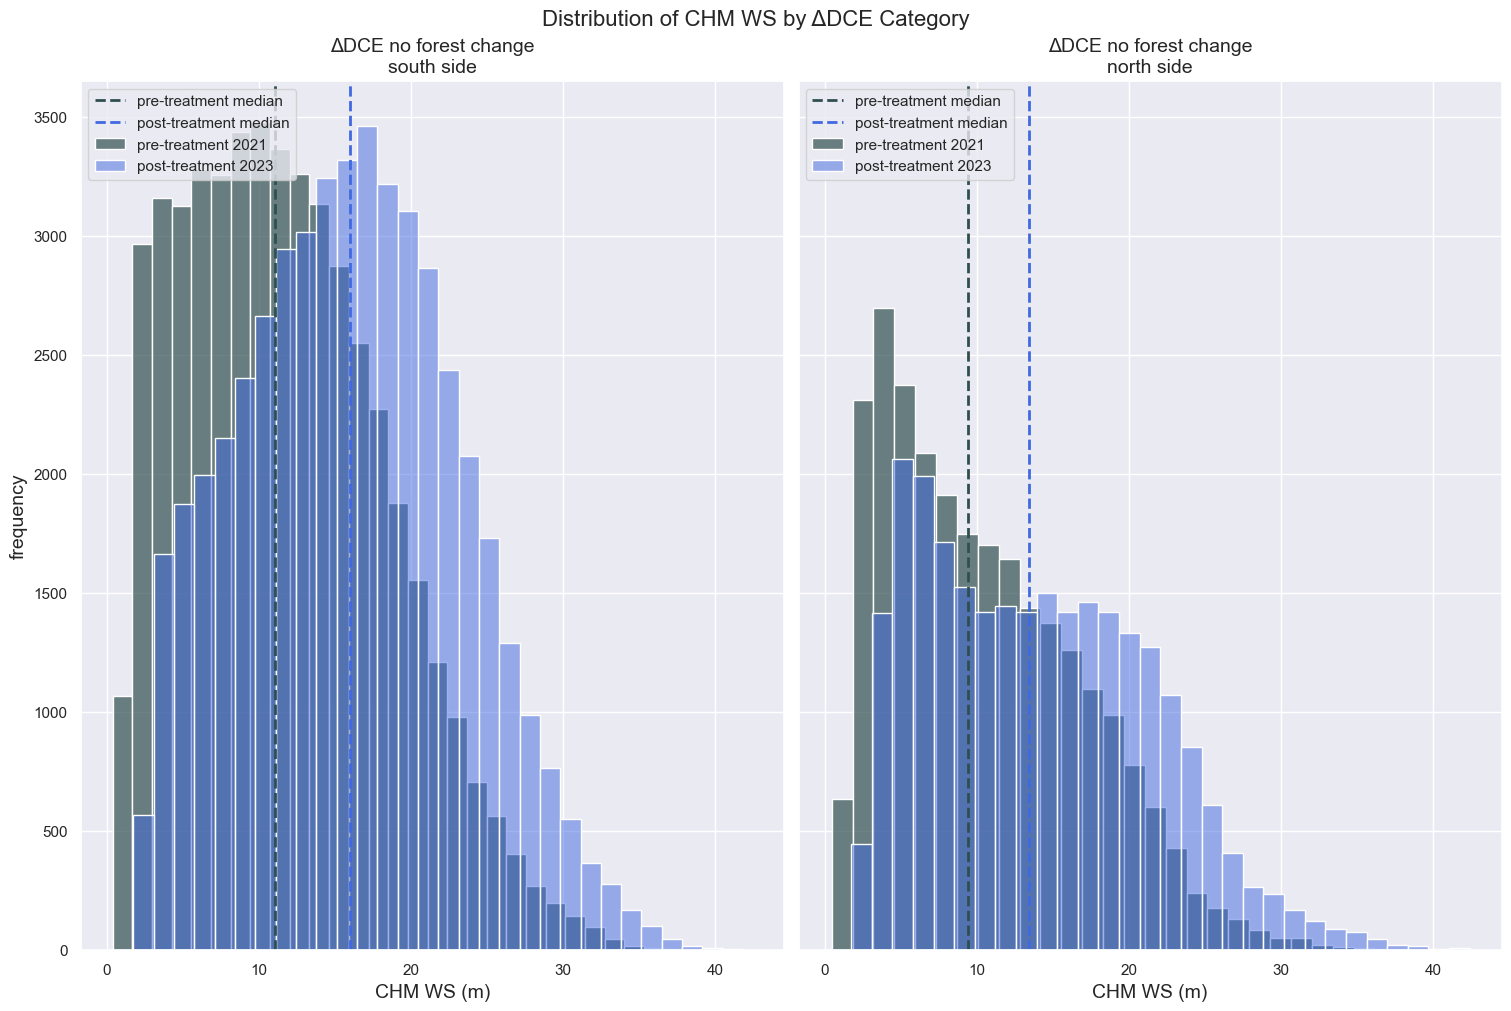

In [21]:
# Now, I want to plot historgrams of the DCE distribution for each category
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,10), constrained_layout = True)
alpha_1=0.7
alpha_2=0.5

color_pre='darkslategray'
color_post='royalblue'

# category 3: no change
axes[0].set_title('ΔDCE no forest change\nsouth side', fontsize=fontsize_num)
axes[1].set_title('ΔDCE no forest change\nnorth side', fontsize=fontsize_num)

# South side data
south_pre = ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten()
south_post = ds['chmws_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten()

# North side data
north_pre = ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten()
north_post = ds['chmws_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten()

# Plot histograms for south side
sns.histplot(south_pre, bins=30, ax=axes[0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(south_post, bins=30, ax=axes[0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# Plot histograms for north side
sns.histplot(north_pre, bins=30, ax=axes[1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(north_post, bins=30, ax=axes[1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# Add vertical median lines
# South side medians
axes[0].axvline(np.nanmedian(south_pre), color=color_pre, linestyle='--', linewidth=2, label='pre-treatment median')
axes[0].axvline(np.nanmedian(south_post), color=color_post, linestyle='--', linewidth=2, label='post-treatment median')

# North side medians
axes[1].axvline(np.nanmedian(north_pre), color=color_pre, linestyle='--', linewidth=2, label='pre-treatment median')
axes[1].axvline(np.nanmedian(north_post), color=color_post, linestyle='--', linewidth=2, label='post-treatment median')

fontsize_num = 14
axes[0].set_xlabel('CHM WS (m)', fontsize=fontsize_num)
axes[1].set_xlabel('CHM WS (m)', fontsize=fontsize_num)

axes[0].set_ylabel('frequency', fontsize=fontsize_num)    

# limit x axis from -10 to 10 
for i in range(2):
    # axes[i].set_xlim(-10,10)
    # axes[i].set_ylim(0,150)
    axes[i].legend(loc='upper left')

plt.suptitle('Distribution of CHM WS by ΔDCE Category', fontsize=16)

plt.show()

CHM instead of DCE for all groups...

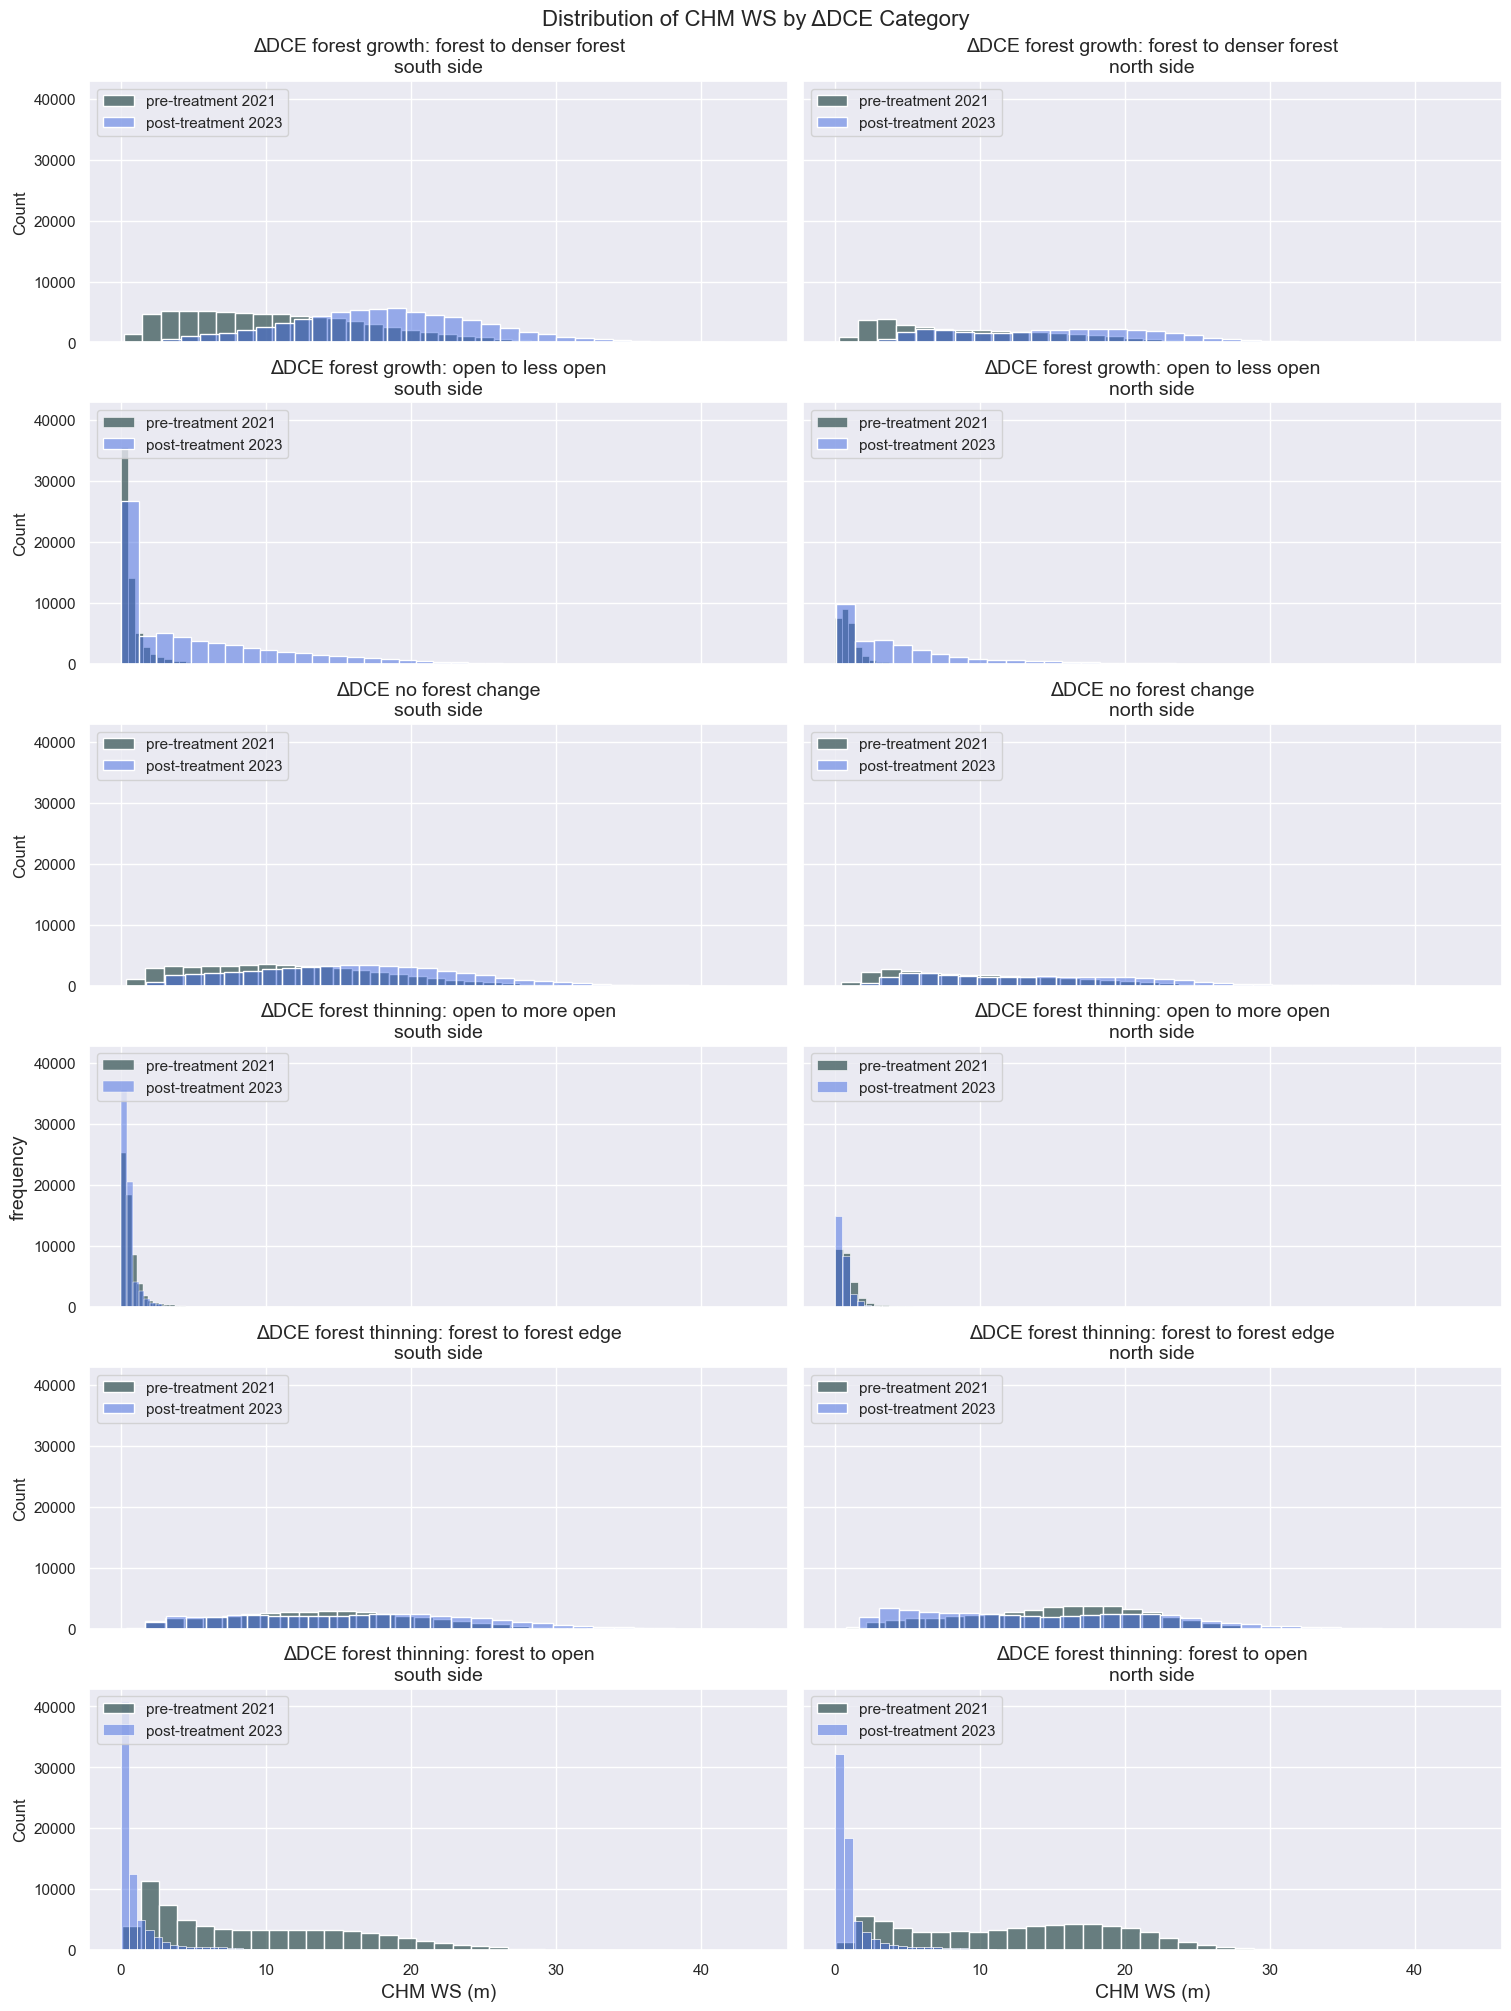

In [20]:
# Now, I want to plot historgrams of the CHM WS distribution for each category
fig, axes = plt.subplots(6, 2, sharex=True, sharey=True, figsize=(15,20), constrained_layout = True)
alpha_1=0.7
alpha_2=0.5

color_pre='darkslategray'
color_post='royalblue'

# SOUTH SIDE OF THE RIDGE, on the left side and NORTH SIDE OF THE RIDGE on the right side 
# category 1: forest to denser forest
axes[0,0].set_title('ΔDCE forest growth: forest to denser forest\nsouth side', fontsize=fontsize_num)
axes[0,1].set_title('ΔDCE forest growth: forest to denser forest\nnorth side', fontsize=fontsize_num)

# south
sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[0,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# north
sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[0,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 1) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[0,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')


# category 2: forest to edge
axes[4,0].set_title('ΔDCE forest thinning: forest to forest edge\nsouth side', fontsize=fontsize_num)
axes[4,1].set_title('ΔDCE forest thinning: forest to forest edge\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[4,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[4,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[4,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 2) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[4,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 3: no change
axes[2,0].set_title('ΔDCE no forest change\nsouth side', fontsize=fontsize_num)
axes[2,1].set_title('ΔDCE no forest change\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[2,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[2,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[2,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 3) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[2,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 4: open to less open
axes[1,0].set_title('ΔDCE forest growth: open to less open\nsouth side', fontsize=fontsize_num)
axes[1,1].set_title('ΔDCE forest growth: open to less open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[1,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[1,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 4) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[1,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 5: open to more open
axes[3,0].set_title('ΔDCE forest thinning: open to more open\nsouth side', fontsize=fontsize_num)
axes[3,1].set_title('ΔDCE forest thinning: open to more open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[3,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[3,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[3,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 5) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[3,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')

# category 6: forest to open
axes[5,0].set_title('ΔDCE forest thinning: forest to open\nsouth side', fontsize=fontsize_num)
axes[5,1].set_title('ΔDCE forest thinning: forest to open\nnorth side', fontsize=fontsize_num)

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[5,0], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == 1)).values.flatten(), bins=30, ax=axes[5,0], color=color_post, alpha=alpha_2, label='post-treatment 2023')

sns.histplot(ds['chmws_ncalm'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[5,1], color=color_pre, alpha=alpha_1, label='pre-treatment 2021')
sns.histplot(ds['chmws_rapid'].where((ds['delta_dce_cat'] == 6) & (ds['baf_ridge'] == -1)).values.flatten(), bins=30, ax=axes[5,1], color=color_post, alpha=alpha_2, label='post-treatment 2023')


fontsize_num = 14
axes[5,0].set_xlabel('CHM WS (m)', fontsize=fontsize_num)
axes[5,1].set_xlabel('CHM WS (m)', fontsize=fontsize_num)

axes[3,0].set_ylabel('frequency', fontsize=fontsize_num)    


# limit x axis from -10 to 10 
for i in range(6):
    for j in range(2):
        axes[i,j].set_xlim(-5,50)
        axes[i,j].legend(loc='upper left')

plt.suptitle('Distribution of CHM WS by ΔDCE Category', fontsize=16)

plt.show()

### Map

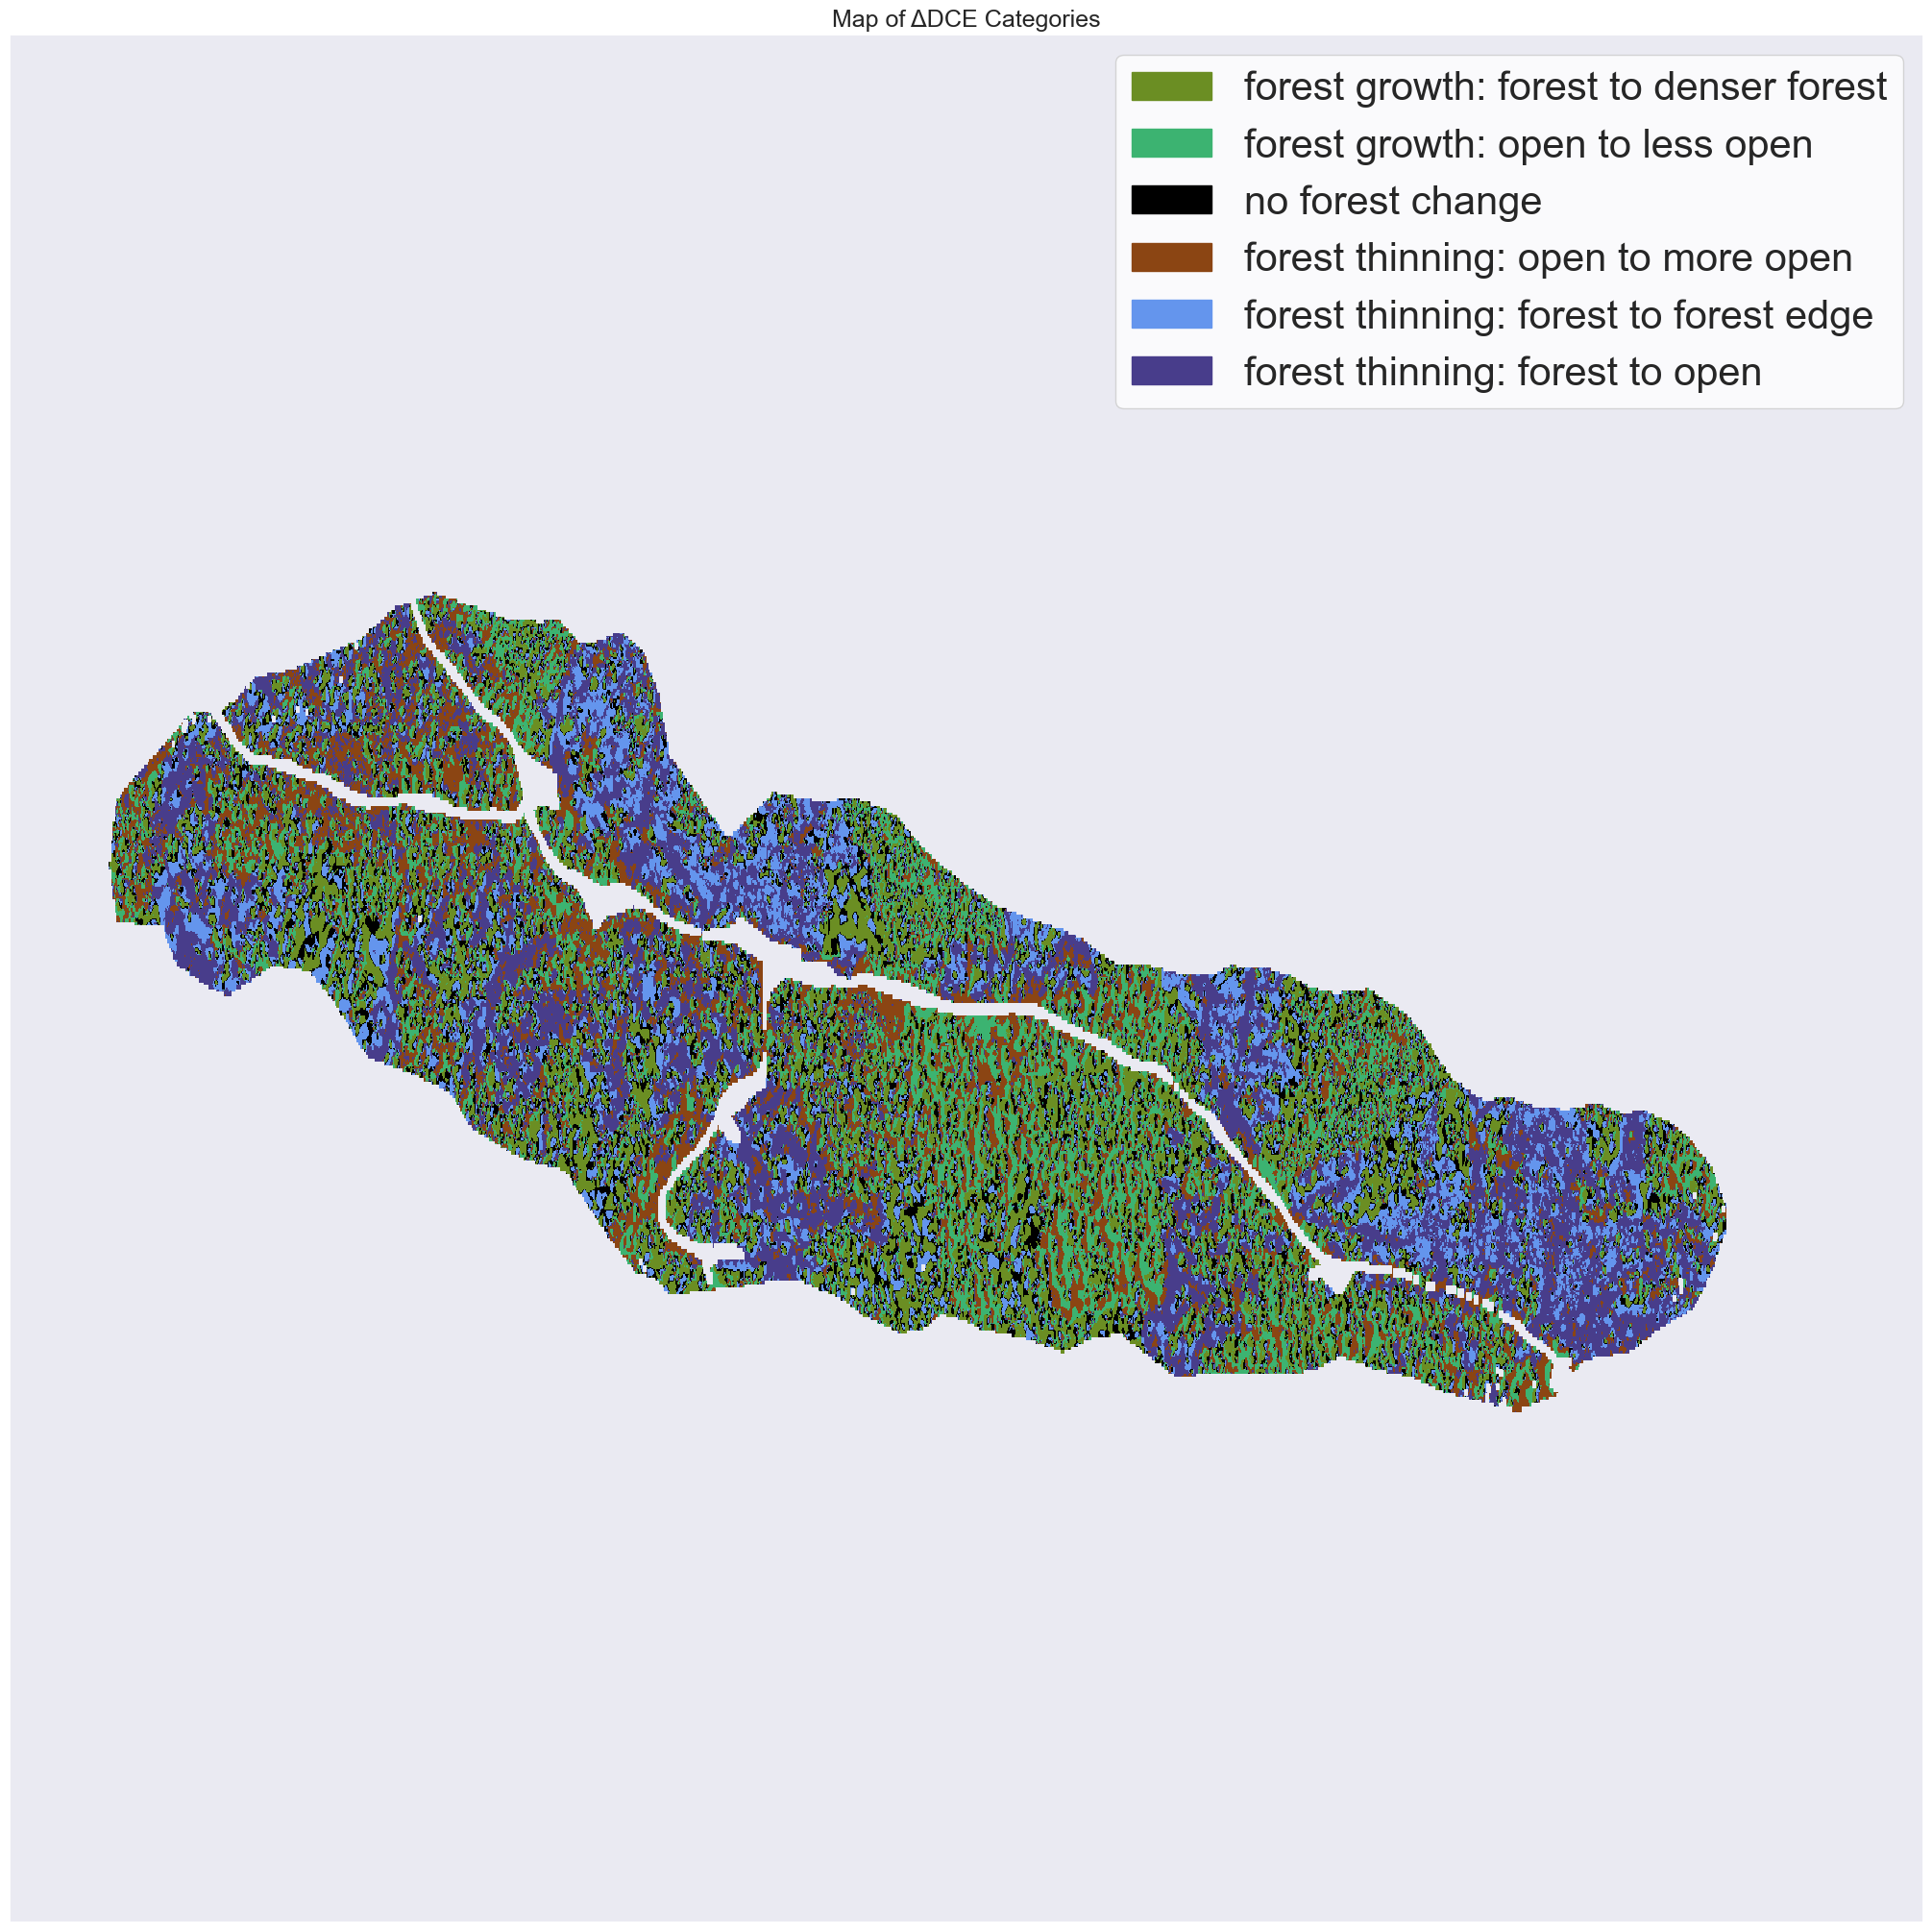

In [15]:
fig = plt.figure(figsize=(20,20), constrained_layout = True)
ax = fig.gca()

# color_zero = 'white'
color_zero = '#EAEAF2'

# plot 3
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
                  color_cat4: "forest growth: open to less open",
                  color_cat3: "no forest change",  
                  color_cat5: "forest thinning: open to more open",               
                  color_cat2: "forest thinning: forest to forest edge",
                  color_cat6: "forest thinning: forest to open",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=30, loc='upper right')

plt.title('')

ax.set_facecolor('black')
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
# ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# add a small C) in the left corner 
# plt.text(0.01, 0.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)

plt.title('Map of ΔDCE Categories', fontsize=18)

# === Save and show ===
# figure_name = 'figure7_map.png'
# plt.savefig(figure_path + figure_name, dpi=500, bbox_inches='tight')

plt.show()